### Importing Various Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Reading CSV files

In [3]:
carriers = pd.read_csv("carriers.csv")
plane_data = pd.read_csv("plane-data.csv")
airports = pd.read_csv("airports.csv")
year_2000 = pd.read_csv("2000.csv")
year_2001 = pd.read_csv("2001.csv", encoding = 'windows-1251')
year_2002 = pd.read_csv("2002.csv", encoding = 'windows-1251')

### Combine all years together into one big dataframe

In [4]:
df_combined = pd.concat([year_2000, year_2001, year_2002], ignore_index=True)

### Cleaning empty data in plane data

In [5]:
plane_data = plane_data.dropna()
plane_data = plane_data.drop(plane_data[plane_data.year == "None"].index)
plane_data = plane_data.drop(plane_data[plane_data.year >= "2002"].index)

### Changing to date format for filtering

In [6]:
plane_data["issue_date"] = pd.to_datetime((plane_data["issue_date"]), format="%m/%d/%Y")

### Removing issue dates before 01 Jan 2003

In [7]:
plane_data = plane_data[~(plane_data["issue_date"] > "2002-12-31")]
plane_data["year"] = pd.to_numeric(plane_data["year"])
plane_data = plane_data.rename(columns={"year": "year_built"})

### Re-indexing plane_data, renaming columns to inner join plane_data and carriers into df_combined

In [8]:
plane_data.reset_index(inplace=True, drop=True)

plane_data = plane_data.rename(columns={"tailnum": "TailNum"})
carriers = carriers.rename(columns={"Code": "UniqueCarrier"})

df_combined = pd.merge(df_combined, plane_data, on = "TailNum")
df_combined = pd.merge(df_combined, carriers, on = "UniqueCarrier")

# Q1: When is the best time of day, day of the week, and time of year to fly to minimise delays?

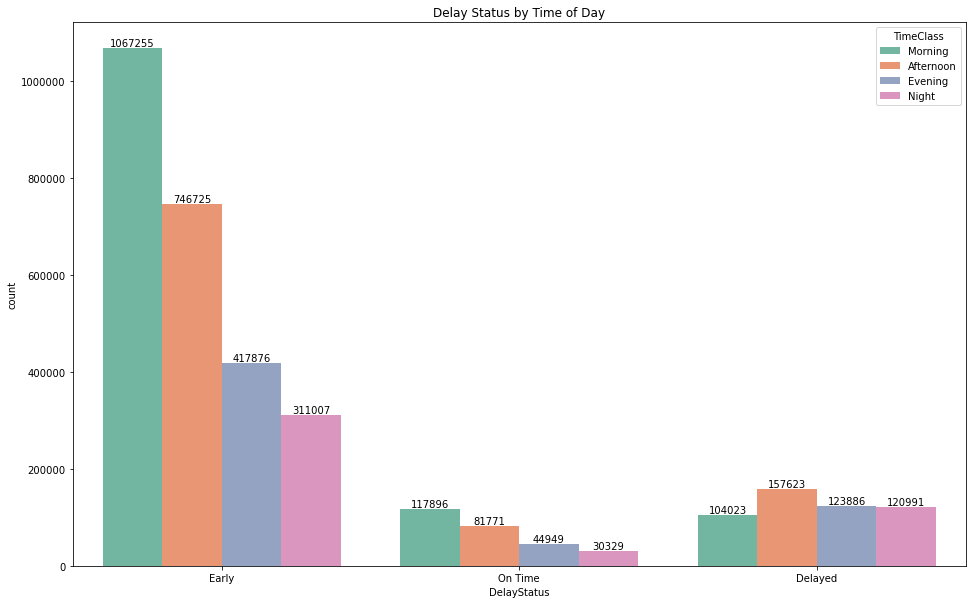

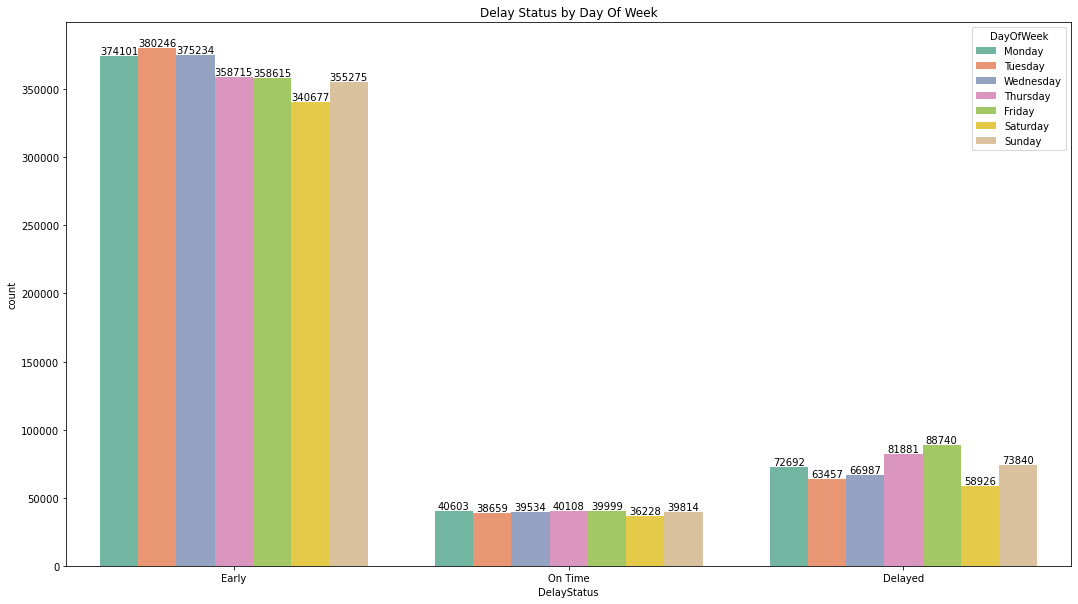

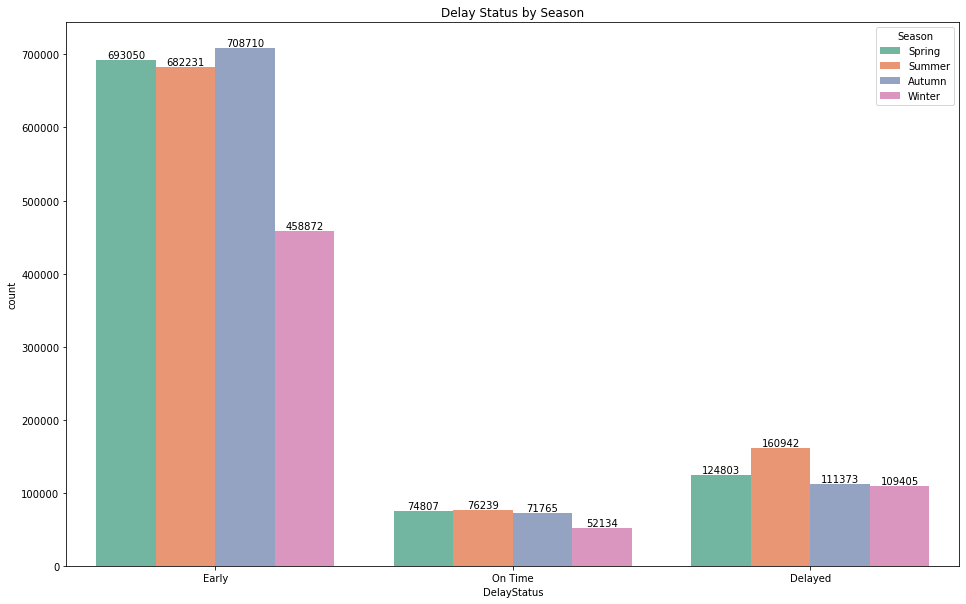

In [9]:
#Create a new data frame, df_best
df_best = df_combined[["Year", "Month", "DayofMonth", "DayOfWeek", "DepTime", "ArrTime", "ArrDelay", "DepDelay"]].copy()
df_best = df_best.dropna()

df_best["DepTime"] = df_best["DepTime"].astype(int)
df_best["ArrTime"] = df_best["ArrTime"].astype(int)
df_best["DepTime"] = df_best["DepTime"].astype(str).str.zfill(4)
df_best["ArrTime"] = df_best["ArrTime"].astype(str).str.zfill(4)
df_best["DepTime"] = df_best["DepTime"].astype(str).str.ljust(5, "0")
df_best["ArrTime"] = df_best["ArrTime"].astype(str).str.ljust(5, "0")

#Changing DepTime and ArrTime to time format
df_best["DepTime"] = pd.to_datetime(df_best["DepTime"], format = "%H%M%S")
df_best["ArrTime"] = pd.to_datetime(df_best["ArrTime"], format = "%H%M%S")

#Get day name from day of week
days = {1:"Monday", 2:"Tuesday", 3:"Wednesday", 4:"Thursday", 5:"Friday", 6:"Saturday", 7:"Sunday"}
df_best["DayOfWeek"] = df_best["DayOfWeek"].map(days)

#Create new column DelayStatus, TotalDelay, Time Classification and Season
df_best["DelayStatus"] = ""
df_best.insert(4, "Season", "")
df_best.insert(4, "TimeClass", "")

#Factoring in the 15 min grace period, assuming that it is already taken into account in the data
conditions = [(df_best["DepDelay"].ge(15)), (df_best["DepDelay"].eq(0)), (df_best["DepDelay"].lt(15)),]
delayStatus = ["Delayed", "On Time", "Early"]
df_best["DelayStatus"] = np.select(conditions, delayStatus)

#Creating column for seasons
seasons = {1: "Winter", 2:"Winter", 3:"Spring", 4:"Spring", 5:"Spring", 6:"Summer", 7:"Summer", 8:"Summer", 9:"Autumn", 10:"Autumn", 11:"Autumn", 12:"Winter"}
df_best["Season"]  = df_best["Month"].apply(lambda x: seasons[x])

#Get time classification
def timeClass(x):
    if (x >= 6) & (x < 12):
        TimeClass = "Morning"
    elif (x >= 12) & (x < 17):
        TimeClass = "Afternoon"
    elif (x >= 17) & (x < 20):
        TimeClass = "Evening"
    else:
        TimeClass = "Night"
    return TimeClass

df_best["TimeClass"] = df_best.DepTime.dt.hour.map(timeClass)
df_best["DepTime"] = pd.to_datetime(df_best["DepTime"], format = "%H%M%S").dt.strftime("%H:%M")
df_best["ArrTime"] = pd.to_datetime(df_best["ArrTime"], format = "%H%M%S").dt.strftime("%H:%M")

#Plots using matplotlib and seaborn
ax = sns.countplot(x = "DelayStatus", hue_order = ["Morning", "Afternoon", "Evening", "Night"], hue = "TimeClass", data = df_best, palette = "Set2")
ax.set_title("Delay Status by Time of Day")
plt.ticklabel_format(style = "plain", axis = "y")
fig = plt.gcf()
fig.set_size_inches(16, 10)
for container in ax.containers: 
   ax.bar_label(container, fmt = "%d")
plt.show()

ax = sns.countplot(x = "DelayStatus", hue_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], hue = "DayOfWeek", data = df_best, palette = "Set2")
ax.set_title("Delay Status by Day Of Week")
plt.ticklabel_format(style = "plain", axis = "y")
fig = plt.gcf()
fig.set_size_inches(18, 10)
for container in ax.containers: 
   ax.bar_label(container, fmt = "%d")
plt.show()

ax = sns.countplot(x = "DelayStatus", hue_order = ["Spring", "Summer", "Autumn", "Winter"], hue = "Season", data = df_best, palette = "Set2")
ax.set_title("Delay Status by Season")
plt.ticklabel_format(style = "plain", axis = "y")
fig = plt.gcf()
fig.set_size_inches(16, 10)
for container in ax.containers: 
   ax.bar_label(container, fmt = "%d")
plt.show()

# Q2: Do older planes suffer more delays?

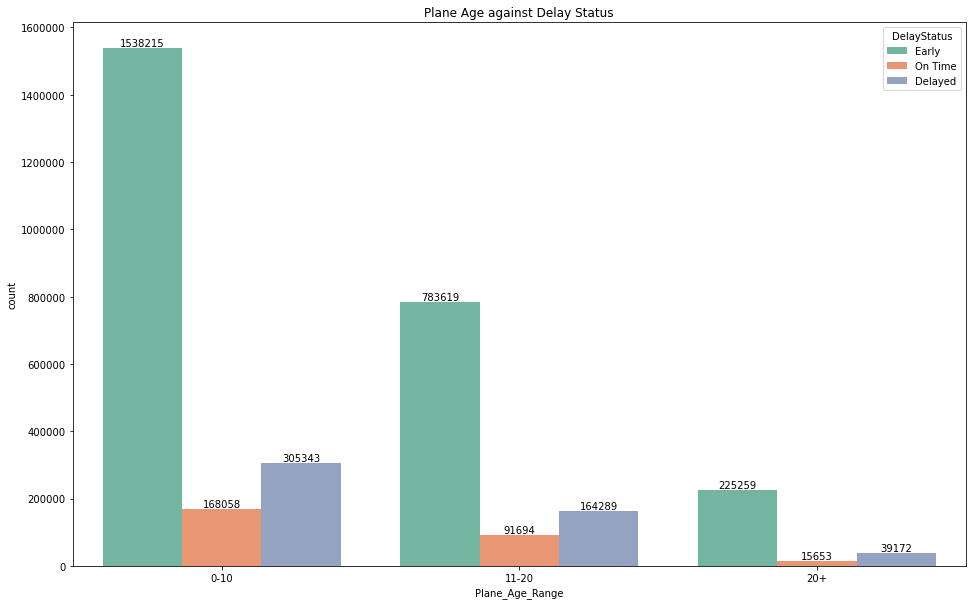

In [10]:
#Creating new column, DelayStatus
df_airplaneAge = df_combined[["Year", "DepDelay", "year_built"]].copy()
df_airplaneAge.insert(2, "DelayStatus", "")

#Referencing from Q1:
conditions2 = [(df_airplaneAge["DepDelay"].ge(15)), (df_airplaneAge["DepDelay"].eq(0)), (df_airplaneAge["DepDelay"].lt(15)),]
delayStatus2 = ["Delayed", "On Time", "Early"]
df_airplaneAge["DelayStatus"] = np.select(conditions2, delayStatus2)
df_airplaneAge = df_airplaneAge.dropna()

#Creating new column, Plane_Age and finding the age of plane
df_airplaneAge["Plane_Age"] = df_airplaneAge["Year"] - df_airplaneAge["year_built"]
df_airplaneAge["Plane_Age_Range"] = ""
df_airplaneAge.loc[df_airplaneAge["Plane_Age"].between(0,10), "Plane_Age_Range"] = "0-10"
df_airplaneAge.loc[df_airplaneAge["Plane_Age"].between(11,20), "Plane_Age_Range"] = "11-20"
df_airplaneAge.loc[df_airplaneAge["Plane_Age"] > 20, "Plane_Age_Range"] = "20+"

#Plot countplot
ax2 = sns.countplot(x = "Plane_Age_Range", hue = "DelayStatus", order = ["0-10", "11-20", "20+"], data = df_airplaneAge, palette = "Set2")
ax2.set_title("Plane Age against Delay Status")
plt.ticklabel_format(style = "plain", axis = "y")
fig = plt.gcf()
fig.set_size_inches(16, 10)
for container in ax2.containers: 
   ax2.bar_label(container, fmt = "%d")
plt.show()

# Q3: How does the number of people flying between different locations change over time?

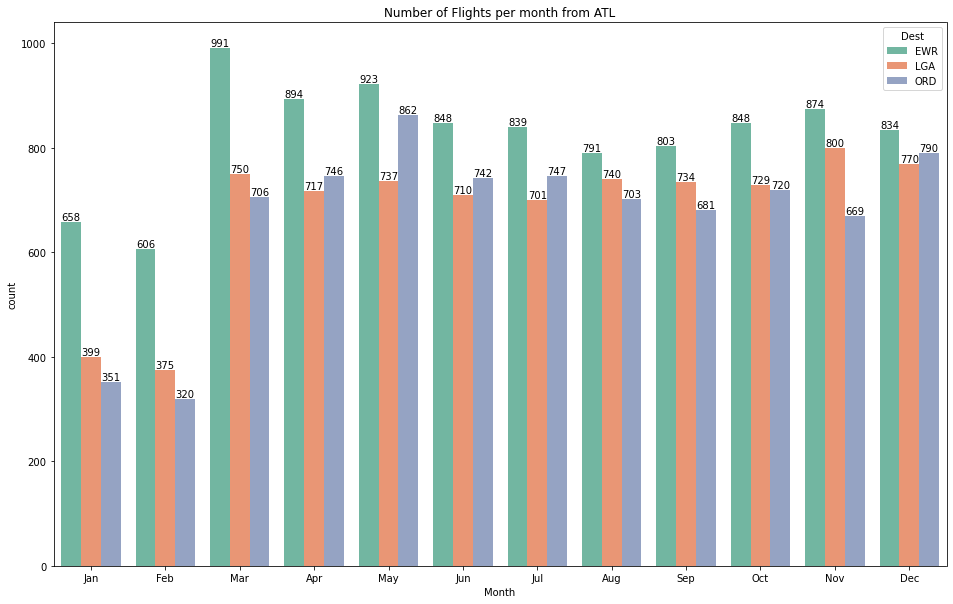

In [11]:
df_people = df_combined[["Year", "Month", "Origin", "Dest"]].copy()
df_people = df_people.rename(columns={"airport": "OriAirport"})
airports = airports.rename(columns={"iata": "Origin"})
df_people = pd.merge(df_people, airports, on = "Origin")
months = {1: "Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}
df_people["Month"]  = df_people["Month"].apply(lambda x: months[x])

#Count the number of flights from each Origin
flight_count = df_people[["Origin"]].copy()
flight_count.groupby("Origin").size()

#Choose ATL(Alanta) as the origin, since it has the highest flight count, and filtering the other Origins out
df_people = df_people[df_people.Origin == "ATL"]

#Count the number of flights from ATL(Atlanta) to each Destination, take the top 3 destinations
dest_count = df_people[["Dest"]].copy()
dest_count.groupby("Dest").size()


#Filter out the other Origins except EWR, LGA and ORD
remove_dest = ["EWR", "LGA", "ORD"]
df_people = df_people[df_people.Dest.isin(remove_dest)]

#Plot countplot
ax3 = sns.countplot(x = "Month", hue = "Dest", order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"], data = df_people, palette = "Set2")
ax3.set_title("Number of Flights per month from ATL")
plt.ticklabel_format(style = "plain", axis = "y")
fig = plt.gcf()
fig.set_size_inches(16, 10)
for container in ax3.containers: 
   ax3.bar_label(container, fmt = "%d")
plt.show()

# Q4: Can you detect cascading failures as delays in one airport create delays in others?

In [14]:
df_cascading_dest = df_combined[["Year", "Month", "DayofMonth", "FlightNum", "TailNum", "CRSDepTime", "DepTime", "DepDelay", "CRSArrTime", "ArrTime", "ArrDelay", "Origin", "Dest"]].copy()
df_cascading_dest = df_cascading_dest[df_cascading_dest.DepDelay >= 15]
df_cascading_dest = df_cascading_dest[df_cascading_dest.ArrDelay > 0]

#Count the number of flights to each Destination(ATL)
cascading_dest_count = df_cascading_dest[["Dest"]].copy()
cascading_dest_count.groupby("Dest").size()

#Choose ATL(Alanta) as the destination, since it has the highest flight delay count, and filtering the other Dest out
df_cascading_dest = df_cascading_dest[df_cascading_dest.Dest == "ATL"]

##Create new data frame, df_cascading_origin
df_cascading_origin = df_combined[["Year", "Month", "DayofMonth", "FlightNum", "TailNum", "CRSDepTime", "DepTime", "DepDelay", "CRSArrTime", "ArrTime", "ArrDelay", "Origin", "Dest"]].copy()
df_cascading_origin = df_cascading_origin[df_cascading_origin.DepDelay >= 15]
df_cascading_origin = df_cascading_origin[df_cascading_origin.ArrDelay > 0]

#Choose ATL(Alanta) as the origin, since it has the highest flight delay count, and filtering the other Origin out
df_cascading_origin = df_cascading_origin[df_cascading_origin.Origin == "ATL"]

#Full join the 2 tables
cascading_main = pd.merge(df_cascading_dest, df_cascading_origin, how = "outer")

#Changing from numeric to time format
cascading_main["DepTime"] = cascading_main["DepTime"].astype(int)
cascading_main["ArrTime"] = cascading_main["ArrTime"].astype(int)
cascading_main["CRSDepTime"] = cascading_main["CRSDepTime"].astype(int)
cascading_main["CRSArrTime"] = cascading_main["CRSArrTime"].astype(int)

cascading_main["DepTime"] = cascading_main["DepTime"].astype(str).str.zfill(4)
cascading_main["ArrTime"] = cascading_main["ArrTime"].astype(str).str.zfill(4)
cascading_main["CRSDepTime"] = cascading_main["CRSDepTime"].astype(str).str.zfill(4)
cascading_main["CRSArrTime"] = cascading_main["CRSArrTime"].astype(str).str.zfill(4)

cascading_main["DepTime"] = cascading_main["DepTime"].astype(str).str.ljust(5, "0")
cascading_main["ArrTime"] = cascading_main["ArrTime"].astype(str).str.ljust(5, "0")
cascading_main["CRSDepTime"] = cascading_main["CRSDepTime"].astype(str).str.ljust(5, "0")
cascading_main["CRSArrTime"] = cascading_main["CRSArrTime"].astype(str).str.ljust(5, "0")
print(cascading_main)

       Year  Month  DayofMonth  FlightNum TailNum CRSDepTime DepTime  \
0      2000      2           2        612  N322AW      13030   14240   
1      2000      1           4        618  N624AW      00470   02310   
2      2000      1           2       2614  N624AW      15520   16300   
3      2000      2          24       2618  N624AW      00470   01060   
4      2000      3          24        613  N624AW      23500   00200   
...     ...    ...         ...        ...     ...        ...     ...   
80488  2002      7          23        733  N326NB      18150   18580   
80489  2002      8          17       1765  N326NB      08450   09050   
80490  2002      3          31        496  N327NB      12050   12200   
80491  2002      8          22       1515  N321NB      06200   06590   
80492  2001      6          15        557  N24211      13400   14040   

       DepDelay CRSArrTime ArrTime  ArrDelay Origin Dest  
0          81.0      18470   20080      81.0    PHX  ATL  
1         104.0  

# Q5: Use the available variables to construct a model that predicts delays.

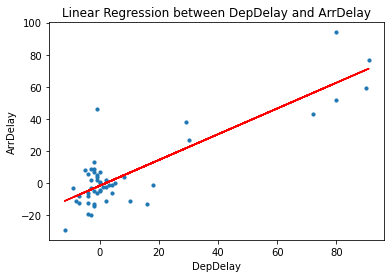

R2 score:  0.7348299220259585


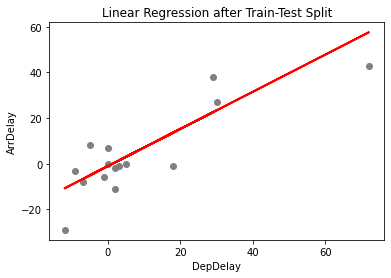

R2 Score:  0.7074824713411824


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#Load data
#Select 50 flights at random
np.random.seed(1)
ml_delay = df_combined.copy()
ml_delay = ml_delay.drop(["CancellationCode", "CarrierDelay", "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay", "type", "manufacturer", "issue_date", "model", "status", "aircraft_type", "engine_type", "year_built", "Description"], axis = 1)
ml_delay = ml_delay.dropna(subset=["DepDelay", "ArrDelay"], how='all')
ml_sample = ml_delay.sample(50)

X = ml_sample["DepDelay"].values.reshape(-1,1)
y = ml_sample["ArrDelay"].values.reshape(-1,1)

regression_model = LinearRegression()
#Fitting of data
regression_model.fit(X, y)
y_predicted = regression_model.predict(X)

#Results
rmse = mean_squared_error(y, y_predicted)
r2 = r2_score(y, y_predicted)

#Plotting
plt.scatter(X, y, s=10)
plt.xlabel('DepDelay')
plt.ylabel('ArrDelay')
plt.title("Linear Regression between DepDelay and ArrDelay")
plt.plot(X, y_predicted, color='r')
plt.show()
print('R2 score: ', r2)

#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
traintest = LinearRegression()
traintest.fit(X_train, y_train) #training the algorithm

y_pred = traintest.predict(X_test)

plt.scatter(X_test, y_test, color="gray")
plt.plot(X_test, y_pred, color="red", linewidth=2)
plt.xlabel('DepDelay')
plt.ylabel('ArrDelay')
plt.title("Linear Regression after Train-Test Split")
plt.show()
r22 = r2_score(y_test, y_pred)
print("R2 Score: ", r22)